In [98]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, butter, lfilter
import scipy
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report


In [ ]:
# Load .mat file
file_path = r"C:\Users\user\Desktop\Brain Hackathon\stroke_rehab_data_analysis\data\P1_pre_training.mat"
data = loadmat(file_path)

# Extract data
fs = int(data['fs'][0][0])      # sampling frequency
trig = data['trig'].flatten()   # flatten from (N,1) → (N,)
y = data['y']                   # signal data (N,16)

# Create a time axis (in seconds)
time = np.arange(y.shape[0]) / fs

# Build dataframe: time, triggers, and all channels
columns = ['time_sec', 'trig'] + [f'ch{i+1}' for i in range(y.shape[1])]
df = pd.DataFrame(
    data = np.column_stack((time, trig, y)),
    columns = columns
)


print("✅ Data exported successfully")
print("Sampling frequency:", fs, "Hz")
print("Data shape:", df.shape)

✅ Data exported successfully
Sampling frequency: 256 Hz
Data shape: (271816, 18)


In [132]:
# Load .mat file
file_path = r"C:\Users\user\Desktop\Brain Hackathon\stroke_rehab_data_analysis\data\P1_pre_test.mat"
test_data = loadmat(file_path)

# Extract data
fs = int(test_data['fs'][0][0])      # sampling frequency
trig = test_data['trig'].flatten()   # flatten from (N,1) → (N,)
y = test_data['y']                   # signal data (N,16)

# Create a time axis (in seconds)
time = np.arange(y.shape[0]) / fs

# Build dataframe: time, triggers, and all channels
columns = ['time_sec', 'trig'] + [f'ch{i+1}' for i in range(y.shape[1])]
test_df = pd.DataFrame(
    data = np.column_stack((time, trig, y)),
    columns = columns
)


print("✅ Data exported successfully")
print("Sampling frequency:", fs, "Hz")
print("Data shape:", test_df.shape)

✅ Data exported successfully
Sampling frequency: 256 Hz
Data shape: (204560, 18)


In [60]:
df.head()

,time_sec,trig,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,ch10,ch11,ch12,ch13,ch14,ch15,ch16
0,0.000000,0.0,38001.839844,36892.000000,46397.214844,50350.613281,37726.980469,57036.867188,46999.265625,47667.355469,47781.109375,39447.503906,49432.898438,48651.296875,49362.050781,47384.273438,38979.992188,61820.179688
1,0.003906,0.0,54828.550781,54868.156250,52444.156250,52408.507812,54521.210938,50932.191406,52738.488281,52781.171875,52272.847656,54376.527344,52604.574219,52560.785156,52507.796875,52978.863281,54474.457031,50255.472656
2,0.007812,0.0,-24629.253906,-24865.400391,-22964.140625,-22914.605469,-24873.259766,-22113.113281,-23516.539062,-23355.142578,-22624.406250,-24587.474609,-23058.496094,-23198.757812,-23129.423828,-23339.222656,-24563.939453,-21289.884766
3,0.011719,0.0,-77839.562500,-78191.210938,-76574.710938,-76846.210938,-78150.195312,-76362.351562,-77222.789062,-77171.906250,-76289.273438,-78103.726562,-77080.812500,-77045.546875,-76983.515625,-77237.015625,-77972.484375,-75860.140625
4,0.015625,0.0,-48999.753906,-49155.601562,-49435.792969,-49648.988281,-49283.152344,-50093.390625,-49608.496094,-49621.535156,-49217.925781,-49437.320312,-49688.796875,-50009.597656,-49660.007812,-49592.742188,-49244.277344,-50159.144531


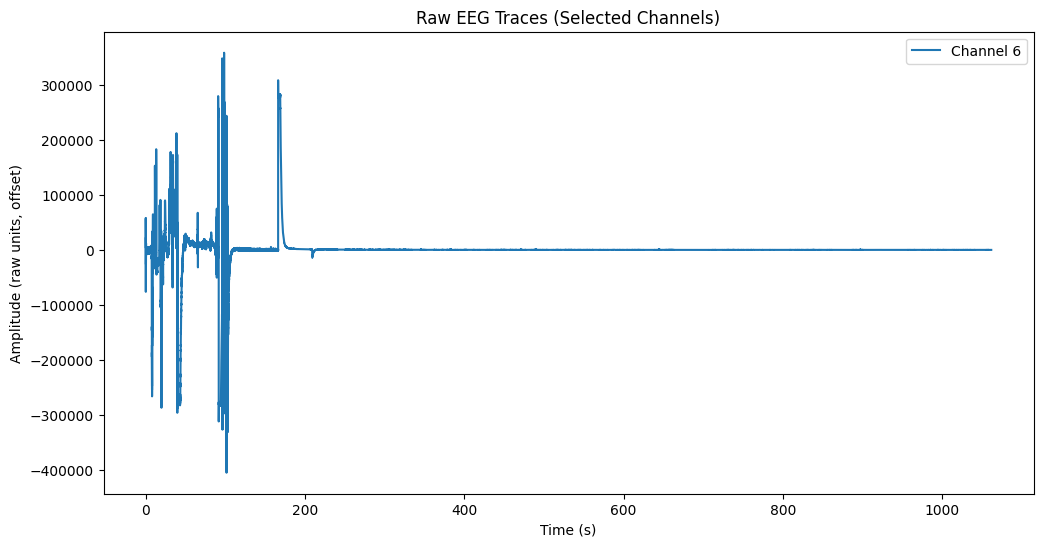

In [61]:

# First column = time, next columns = EEG channels
time = df.iloc[:, 0].values
eeg = df.iloc[:, 2:].values   # skipping col 1 if it's a trigger channel

# Choose some channels to plot (e.g., first 5 EEG channels)
channels_to_plot = [5]

offset = 50000 #vertical spacing between channels

plt.figure(figsize=(12, 6))

for i, ch in enumerate(channels_to_plot):
    plt.plot(time, eeg[:, ch] + i*offset, label=f'Channel {ch+1}')
    # offset each channel vertically (50000 = shift, adjust based on your data scale)

plt.xlabel("Time (s)")
plt.ylabel("Amplitude (raw units, offset)")
plt.title("Raw EEG Traces (Selected Channels)")
plt.legend()
plt.show()


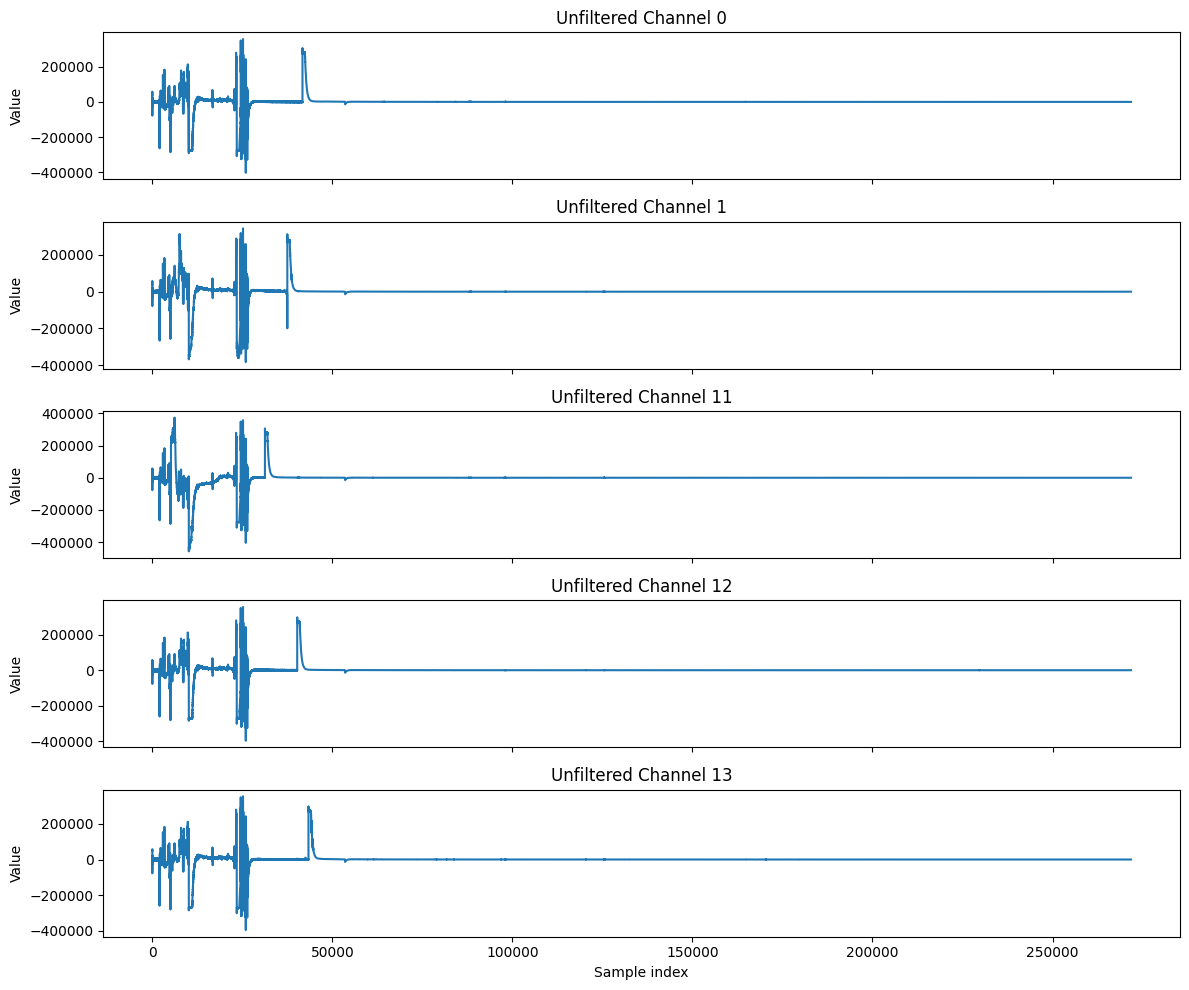

In [135]:

channels_to_plot = [2, 3, 13 , 14, 15]  # 0-based indices for ch 1,3,5,7,9,14

fig, axes = plt.subplots(len(channels_to_plot), 1, figsize=(12, 10), sharex=True)

for i, ch in enumerate(channels_to_plot):
    axes[i].plot(df.iloc[:, ch])
    axes[i].set_title(f'Unfiltered Channel {ch-2}')
    axes[i].set_ylabel("Value")
    
axes[-1].set_xlabel("Sample index")
plt.tight_layout()
plt.show()


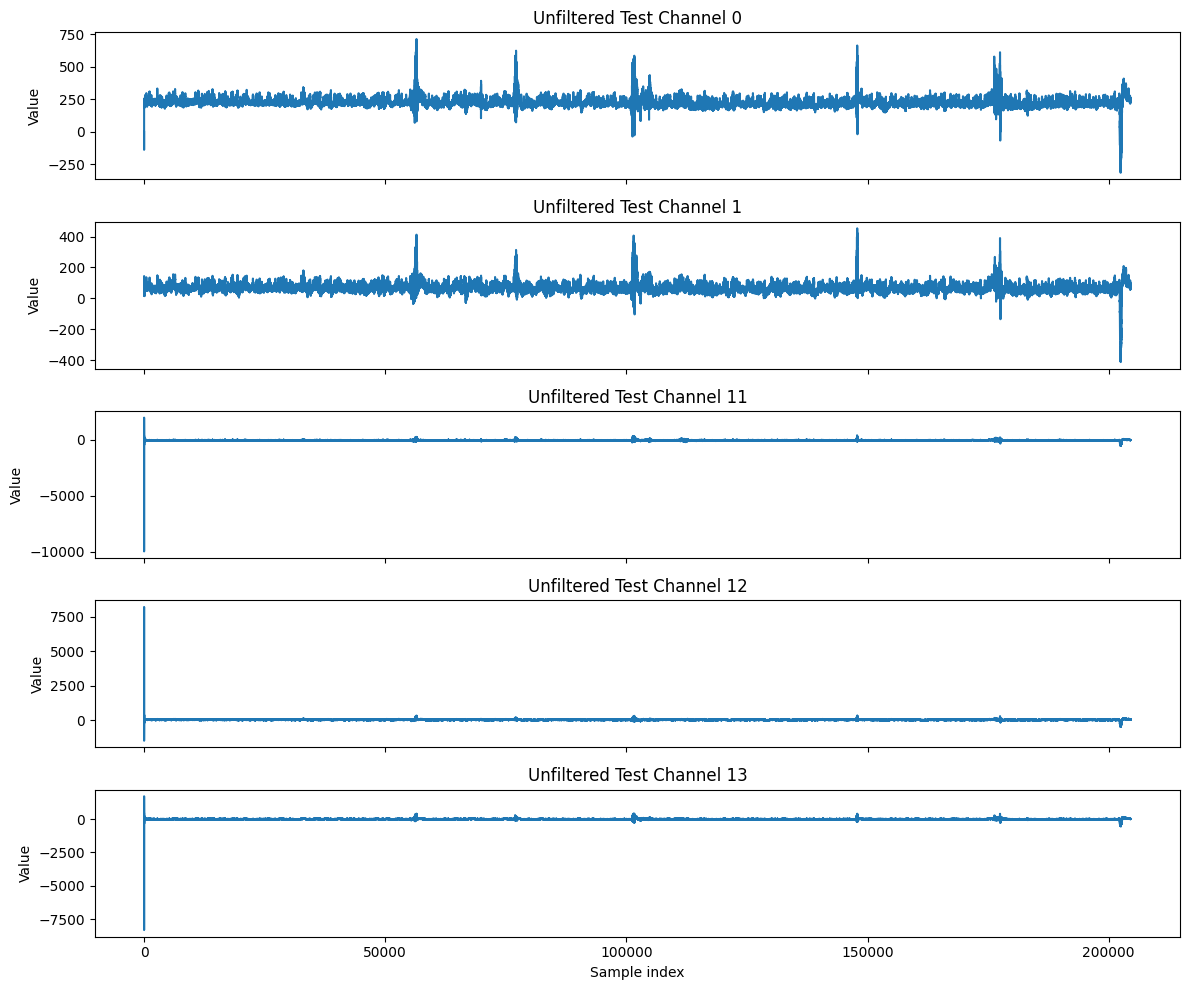

In [137]:

channels_to_plot = [2, 3, 13 , 14, 15,]  # 0-based indices for ch 1,3,5,7,9,14

fig, axes = plt.subplots(len(channels_to_plot), 1, figsize=(12, 10), sharex=True)

for i, ch in enumerate(channels_to_plot):
    axes[i].plot(test_df.iloc[:, ch])
    axes[i].set_title(f'Unfiltered Test Channel {ch-2}')
    axes[i].set_ylabel("Value")
    
axes[-1].set_xlabel("Sample index")
plt.tight_layout()
plt.show()


Left trials: (81920, 1280, 16)
Right trials: (80913, 1280, 16)


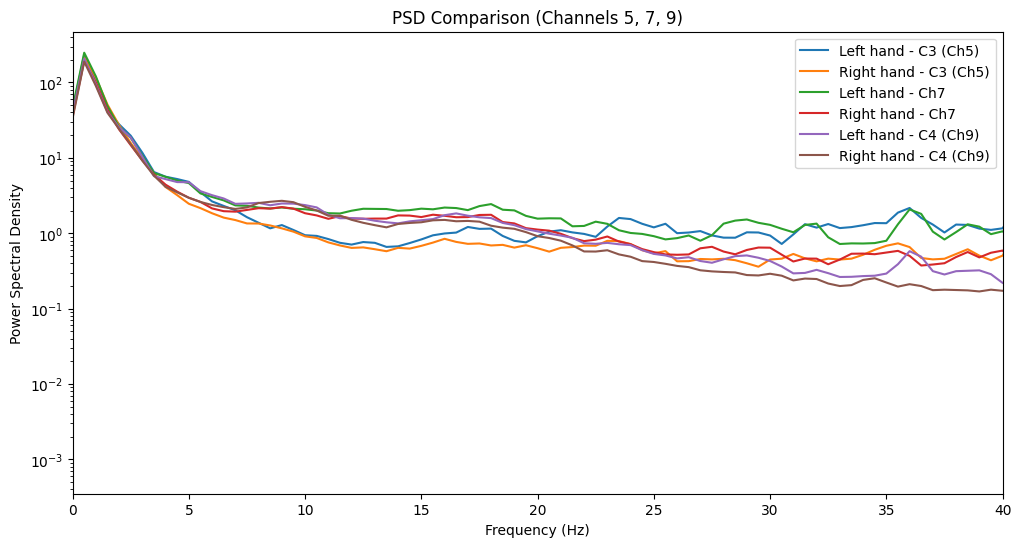

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# ==== PARAMETERS ====
fs = 256                   # Sampling frequency
pre_time, post_time = 1, 4 # Epoch window: 1s before, 4s after trigger

# ==== LOAD DATA ====
time = df.iloc[:, 0].values
trigger = df.iloc[:, 1].values
eeg = df.iloc[:, 2:].values   # EEG channels only

# ==== EPOCH EXTRACTION ====
epoch_len = int((pre_time + post_time) * fs)
event_indices = np.where(trigger != 0)[0]

epochs_left, epochs_right = [], []

for idx in event_indices:
    label = trigger[idx]
    start = idx - int(pre_time * fs)
    end = idx + int(post_time * fs)
    if start < 0 or end > len(eeg):
        continue
    epoch = eeg[start:end, :]  # shape: (epoch_len, n_channels)
    if label == 1:   # left hand
        epochs_left.append(epoch)
    elif label == -1: # right hand
        epochs_right.append(epoch)

epochs_left = np.array(epochs_left)
epochs_right = np.array(epochs_right)

print("Left trials:", epochs_left.shape)
print("Right trials:", epochs_right.shape)

# ==== PSD FUNCTION ====
def compute_mean_psd(epochs, ch_idx, fs=256):
    psds = []
    for trial in epochs:
        f, Pxx = welch(trial[:, ch_idx], fs=fs, nperseg=fs*2)
        psds.append(Pxx)
    return f, np.mean(psds, axis=0)

# ==== CHANNELS TO COMPARE ====
# Channel 5 → index 4, Channel 7 → index 6, Channel 9 → index 8
channels_to_compare = [4, 6, 8]
labels = ["C3 (Ch5)", "Ch7", "C4 (Ch9)"]

# ==== PLOTTING ====
plt.figure(figsize=(12, 6))

for ch_idx, label in zip(channels_to_compare, labels):
    f, psd_left = compute_mean_psd(epochs_left, ch_idx, fs)
    _, psd_right = compute_mean_psd(epochs_right, ch_idx, fs)

    plt.semilogy(f, psd_left, label=f"Left hand - {label}")
    plt.semilogy(f, psd_right, label=f"Right hand - {label}")

plt.xlim(0, 40)   # Focus on 0–40 Hz
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.title("PSD Comparison (Channels 5, 7, 9)")
plt.legend()
plt.show()


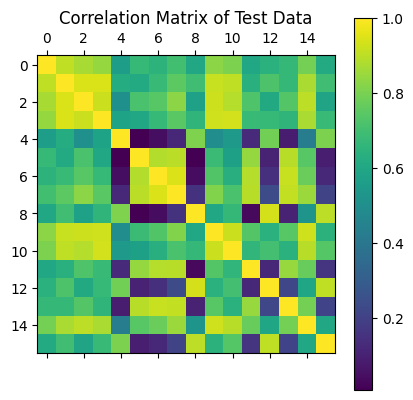

In [145]:
selected_features = test_df.iloc[:, 2:]
plt.matshow(np.corrcoef(selected_features.T))
plt.colorbar()
plt.title('Correlation Matrix of Test Data')
plt.show()# Select columns from the 3rd onward (0-based indexing)


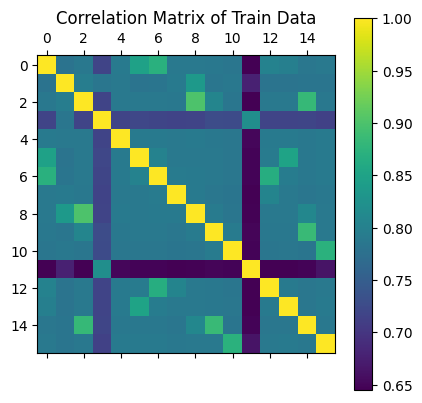

In [146]:
selected_features = df.iloc[:, 2:]
plt.matshow(np.corrcoef(selected_features.T))
plt.colorbar()
plt.title('Correlation Matrix of Train Data')
plt.show()# Select columns from the 3rd onward (0-based indexing)

In [82]:

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = scipy.signal.lfilter(b, a, data)
    return y

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def one_hot(y_):
    y_ = y_.reshape(len(y_))
    y_ = [int(xx) for xx in y_]
    n_values = np.max(y_) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]

Filtration using Band Pass filter and performing visualization and Correlation Matrix again


In [150]:

# Convert DataFrame to NumPy array
test_data_array = test_df.to_numpy()
print("Shape of original data:", test_data_array.shape)

# Separate label (second column) and EEG features (all other columns except label and time)
label = test_data_array[:, 1:2]       # second column as label
features = np.delete(test_data_array, [0, 1], axis=1)  # remove first column (time) and second (label)
n_channels = features.shape[1]

# Initialize array for filtered features
test_feature_f = np.zeros_like(features)

# Bandpass filter parameters
fs = 256.0
lowcut = 7
highcut = 30

# Apply bandpass filter to each channel
for i in range(n_channels):
    test_feature_f[:, i] = butter_bandpass_filter(features[:, i], lowcut, highcut, fs, order=3)

print('Shape of filtered features:', test_feature_f.shape)

# Combine filtered EEG features with label
test_data_cleaned = np.hstack((test_feature_f, label))
print('Shape of cleaned dataset:', test_data_cleaned.shape)


Shape of original data: (204560, 18)
Shape of filtered features: (204560, 16)
Shape of cleaned dataset: (204560, 17)


In [151]:

# Convert DataFrame to NumPy array
train_data_array = df.to_numpy()
print("Shape of original data:", train_data_array.shape)

# Separate label (second column) and EEG features (all other columns except label and time)
label = train_data_array[:, 1:2]       # second column as label
features = np.delete(train_data_array, [0, 1], axis=1)  # remove first column (time) and second (label)
n_channels = features.shape[1]

# Initialize array for filtered features
train_feature_f = np.zeros_like(features)

# Bandpass filter parameters
fs = 256.0
lowcut = 7
highcut = 30

# Apply bandpass filter to each channel
for i in range(n_channels):
    train_feature_f[:, i] = butter_bandpass_filter(features[:, i], lowcut, highcut, fs, order=3)

print('Shape of filtered features:', train_feature_f.shape)

# Combine filtered EEG features with label
train_data_cleaned = np.hstack((train_feature_f, label))
print('Shape of cleaned dataset:', train_data_cleaned.shape)


Shape of original data: (271816, 18)
Shape of filtered features: (271816, 16)
Shape of cleaned dataset: (271816, 17)


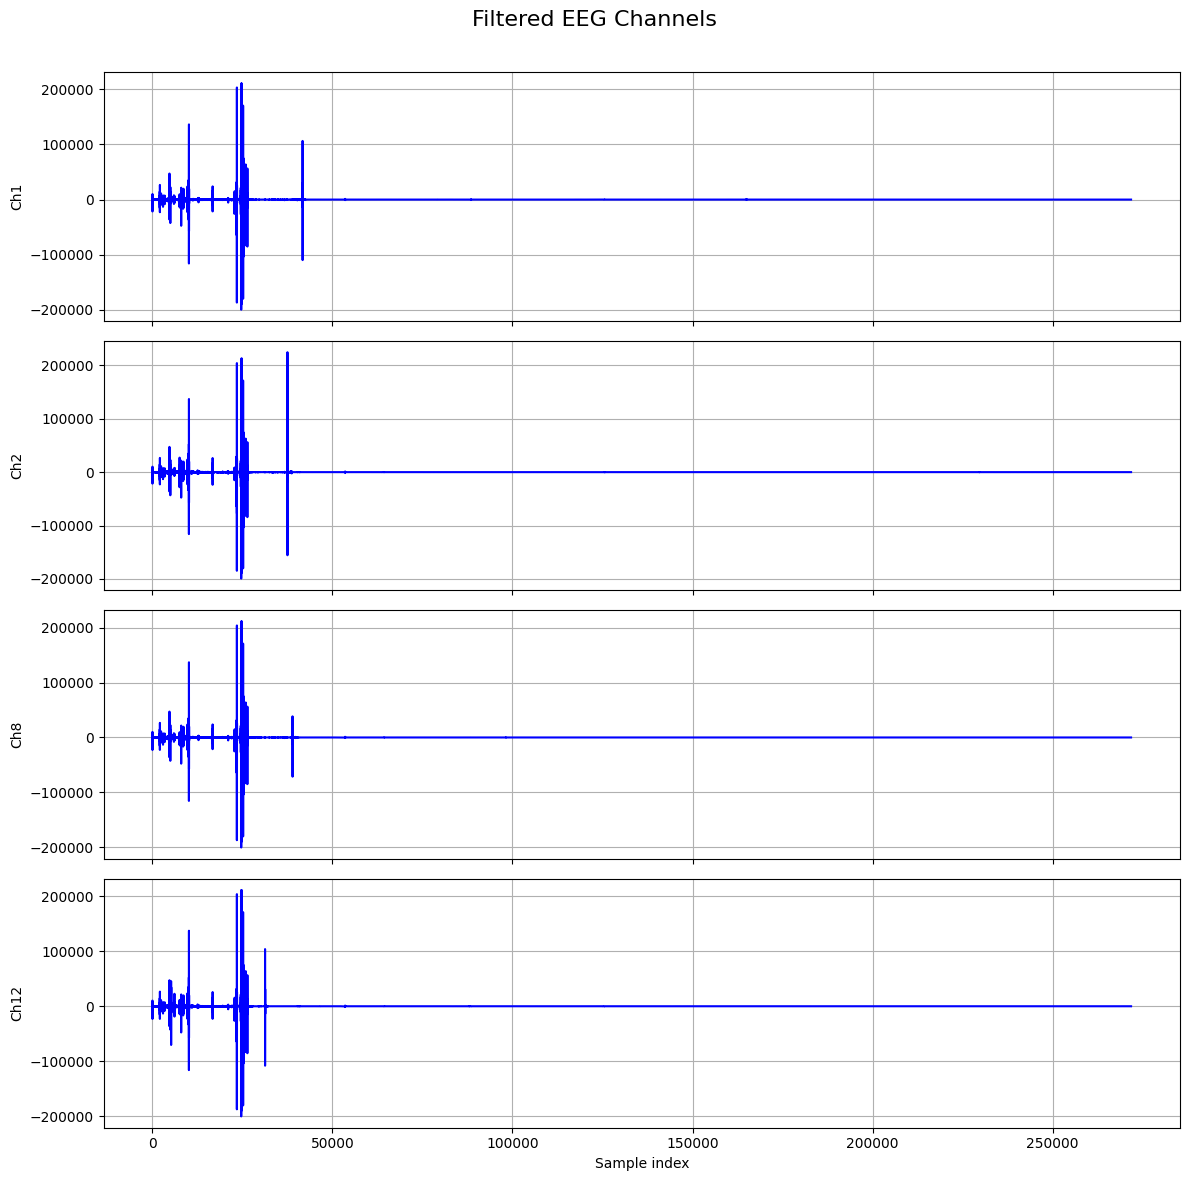

In [ ]:
import matplotlib.pyplot as plt

# Example: choose channels you want to plot (1-based indexing)
channels_to_plot = [1, 2, 8, 12]  # Ch1, Ch5, Ch8, Ch12

# Convert to 0-based indices for Python
channels_to_plot = [ch-1 for ch in channels_to_plot]

# Create subplots
fig, axes = plt.subplots(len(channels_to_plot), 1, figsize=(12, 3*len(channels_to_plot)), sharex=True)

for i, ch in enumerate(channels_to_plot):
    axes[i].plot(train_feature_f[:, ch], color='blue')
    axes[i].set_ylabel(f'Ch{ch+1}')
    axes[i].grid(True)

axes[-1].set_xlabel('Sample index')
plt.suptitle('Train Filtered EEG Channels', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


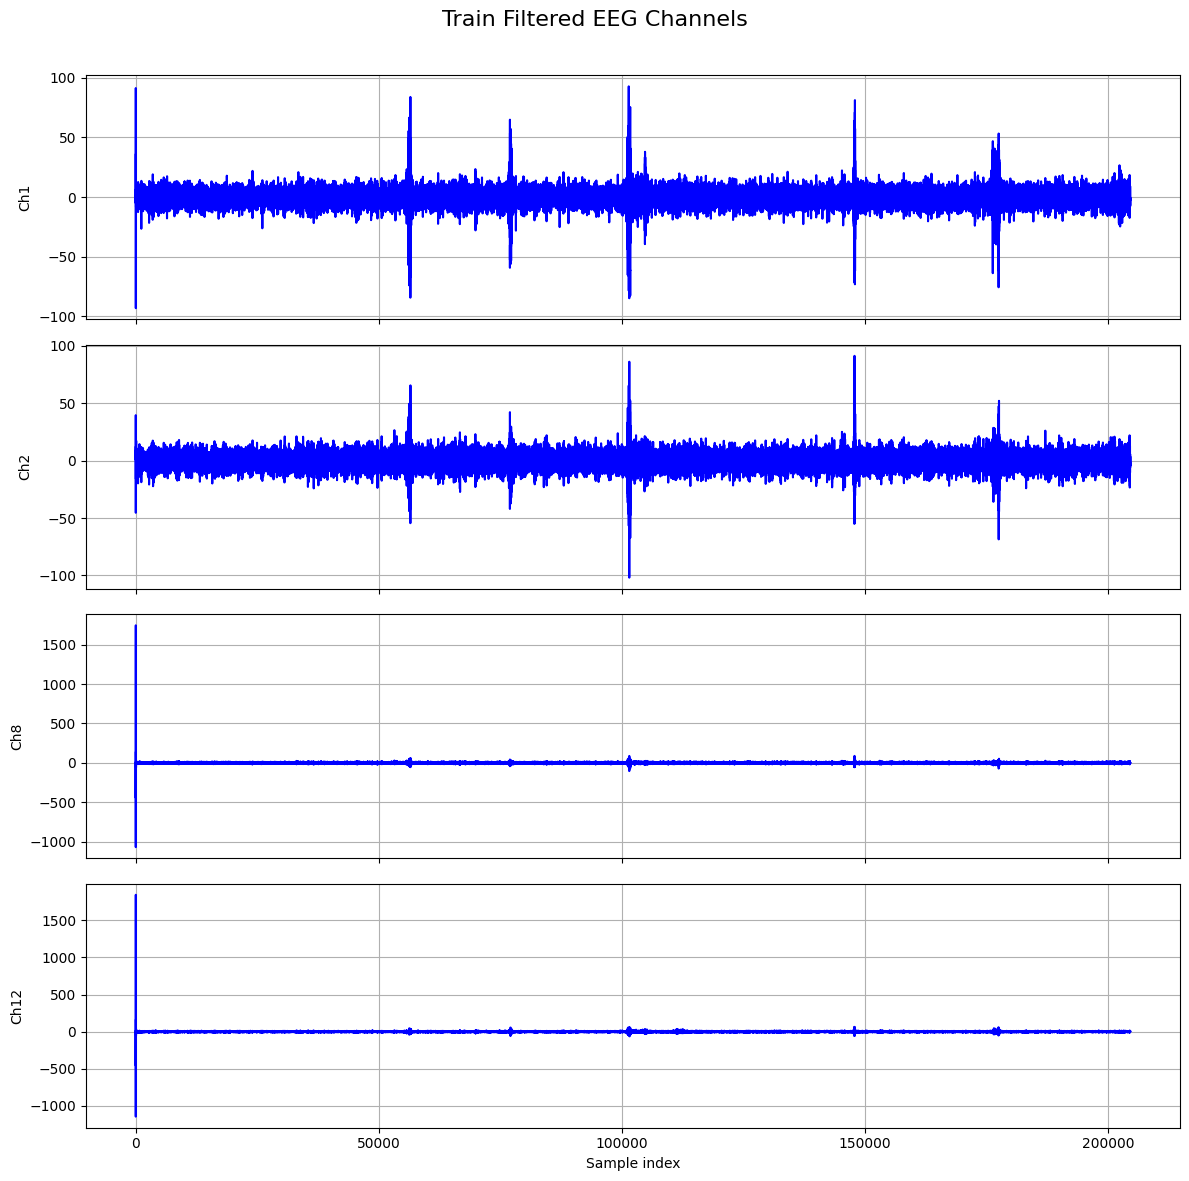

In [155]:
import matplotlib.pyplot as plt

# Example: choose channels you want to plot (1-based indexing)
channels_to_plot = [1, 2, 8, 12]  # Ch1, Ch5, Ch8, Ch12

# Convert to 0-based indices for Python
channels_to_plot = [ch-1 for ch in channels_to_plot]

# Create subplots
fig, axes = plt.subplots(len(channels_to_plot), 1, figsize=(12, 3*len(channels_to_plot)), sharex=True)

for i, ch in enumerate(channels_to_plot):
    axes[i].plot(test_feature_f[:, ch], color='blue')
    axes[i].set_ylabel(f'Ch{ch+1}')
    axes[i].grid(True)

axes[-1].set_xlabel('Sample index')
plt.suptitle('Train Filtered EEG Channels', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


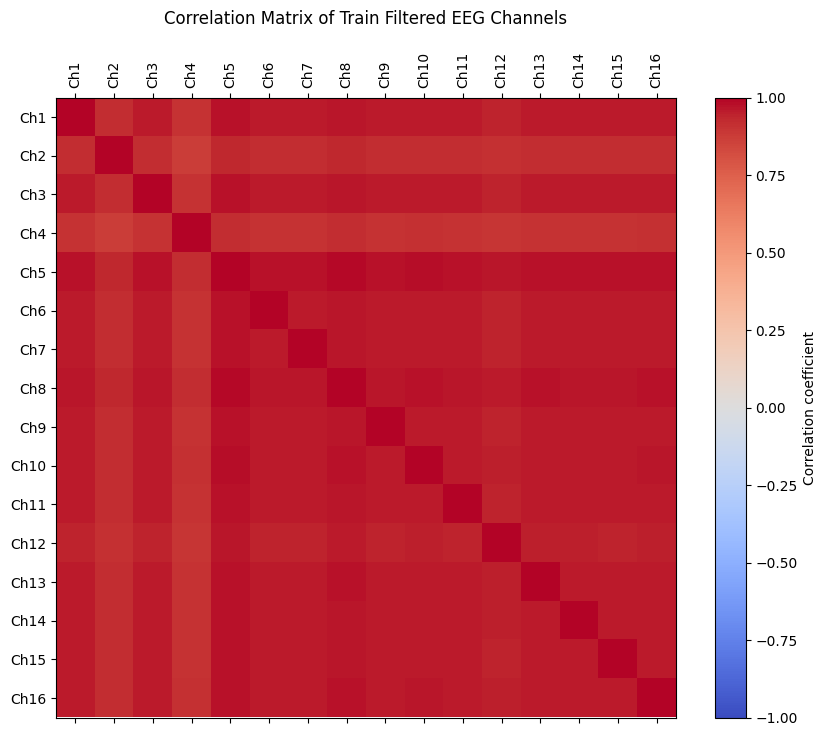

In [159]:
# Compute correlation matrix (channels along columns)
corr_matrix = np.corrcoef(train_feature_f.T)  # transpose so channels are rows

# Plot correlation matrix
plt.figure(figsize=(10, 8))
plt.matshow(corr_matrix, fignum=1, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation coefficient')
plt.title('Correlation Matrix of Train Filtered EEG Channels', pad=20)

# Label axes
n_channels = train_feature_f.shape[1]
plt.xticks(ticks=np.arange(n_channels), labels=[f'Ch{i+1}' for i in range(n_channels)], rotation=90)
plt.yticks(ticks=np.arange(n_channels), labels=[f'Ch{i+1}' for i in range(n_channels)])

plt.show()

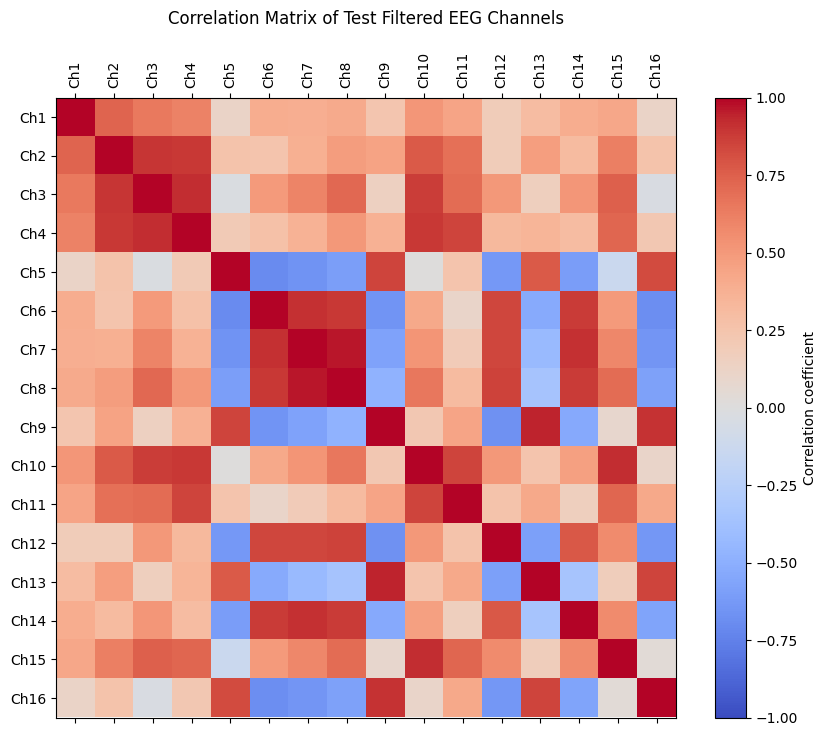

In [158]:
# Compute correlation matrix (channels along columns)
corr_matrix = np.corrcoef(test_feature_f.T)  # transpose so channels are rows

# Plot correlation matrix
plt.figure(figsize=(10, 8))
plt.matshow(corr_matrix, fignum=1, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation coefficient')
plt.title('Correlation Matrix of Test Filtered EEG Channels', pad=20)

# Label axes
n_channels = test_feature_f.shape[1]
plt.xticks(ticks=np.arange(n_channels), labels=[f'Ch{i+1}' for i in range(n_channels)], rotation=90)
plt.yticks(ticks=np.arange(n_channels), labels=[f'Ch{i+1}' for i in range(n_channels)])

plt.show()

In [160]:
def extract(input, n_classes, n_fea, time_window, moving):
    xx = input[:, :n_fea]
    yy = input[:, n_fea:n_fea + 1]
    new_x = []
    new_y = []
    number = int((xx.shape[0] / moving) - 1)
    for i in range(number):
        ave_y = np.average(yy[int(i * moving):int(i * moving + time_window)])
        if ave_y in range(n_classes + 1):
            new_x.append(xx[int(i * moving):int(i * moving + time_window), :])
            new_y.append(ave_y)
        else:
            new_x.append(xx[int(i * moving):int(i * moving + time_window), :])
            new_y.append(0)

    new_x = np.array(new_x)
    new_x = new_x.reshape([-1, n_fea * time_window])
    new_y = np.array(new_y)
    new_y.shape = [new_y.shape[0], 1]
    data = np.hstack((new_x, new_y))
    data = np.vstack((data, data[-1]))  # add the last sample again, to make the sample number round
    return data

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Parameters
segment_length = 16       # time window
moving = segment_length // 2  # 50% overlap

# -------------------------
# 1️⃣ Filter out rest (0) from label (last column)
train_data = train_data_cleaned[train_data_cleaned[:, -1] != 0]
test_data  = test_data_cleaned[test_data_cleaned[:, -1] != 0]  # assuming test_data is separate

# -------------------------
# 2️⃣ Separate features and labels (optional before segmentation)
train_labels = train_data[:, -1].reshape(-1, 1)
train_features = train_data[:, :-1]

test_labels = test_data[:, -1].reshape(-1, 1)
test_features = test_data[:, :-1]

no_feature = train_features.shape[1]

# -------------------------
# 3️⃣ Segment the data
train_seg = extract(train_data, n_classes=2, n_fea=no_feature,
                    time_window=segment_length, moving=moving)
test_seg = extract(test_data, n_classes=2, n_fea=no_feature,
                   time_window=segment_length, moving=moving)

# -------------------------
# 4️⃣ Split features and labels from segments
no_longfeature = no_feature * segment_length

train_seg_feature = train_seg[:, :no_longfeature]
train_seg_label   = train_seg[:, no_longfeature:]

test_seg_feature = test_seg[:, :no_longfeature]
test_seg_label   = test_seg[:, no_longfeature:]

# -------------------------
#  Map labels from -1/1 → 0/1 for binary classification
train_seg_label = np.where(train_seg_label == -1, 0, 1)
test_seg_label  = np.where(test_seg_label == -1, 0, 1)

# -------------------------
# 5️⃣ Normalize features (per channel)
train_feature_2d = train_seg_feature.reshape([-1, no_feature])
test_feature_2d  = test_seg_feature.reshape([-1, no_feature])

scaler = StandardScaler().fit(train_feature_2d)

train_fea_norm = scaler.transform(train_feature_2d)
test_fea_norm  = scaler.transform(test_feature_2d)

# -------------------------
# 6️⃣ Reshape to 3D for LSTM
train_fea_norm = train_fea_norm.reshape([-1, segment_length, no_feature])
test_fea_norm  = test_fea_norm.reshape([-1, segment_length, no_feature])

train_seg_label = train_seg_label.reshape([-1, segment_length, 1])
test_seg_label  = test_seg_label.reshape([-1, segment_length, 1])

print("Training features shape:", train_fea_norm.shape)
print("Test features shape:", test_fea_norm.shape)


Training features shape: (20480, 16, 16)
Test features shape: (20480, 16, 16)
